In [1]:
import captum 
import torch
import optuna
import cv2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from torchvision import transforms

from sklearn.model_selection import train_test_split

from captum.attr import visualization as viz

from optuna_funcs import load_data, objective
from cnn import CNN, ResNet, CNNTransferLearning

Loading data.

In [2]:
baseline = torch.load('best_models/mandioca_baseline.pth', map_location='cpu', weights_only=True)
plantvillage_da = torch.load('best_models/mandioca_plantvillage_domain_adaptation.pth', map_location='cpu', weights_only=True)
plantvillage_ft = torch.load('best_models/mandioca_plantvillage_fine_tuning.pth', map_location='cpu', weights_only=True)
resnet_da = torch.load('best_models/mandioca_resnet_domain_adaptation.pth', map_location='cpu', weights_only=True)
resnet_ft = torch.load('best_models/mandioca_resnet_fine_tuning.pth', map_location='cpu', weights_only=True)

In [3]:
SEED = 42
images, labels, names = load_data(name='mandioca', root="../../digipathos/")

TEST_SIZE = 0.1

x, y = images.numpy(), labels.numpy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=TEST_SIZE, stratify=y, random_state=SEED)
names_train, names_test = train_test_split(names, test_size=TEST_SIZE, stratify=names, random_state=SEED)

x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

test_transforms = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

x_test = test_transforms(x_test)

Loading and instantiating models.

In [4]:
n_classes = 3

# Baseline
STUDY_NAME = 'mandioca_baseline'
study = optuna.load_study(study_name=STUDY_NAME, storage=f'sqlite:///hp_tuning/{STUDY_NAME}.db')

df = pd.read_csv(f'cross_validation/{STUDY_NAME}.csv')
columns = df.filter(like="Cross_Val")
df['Mean'] = columns.mean(axis=1)
df = df.drop(columns="Unnamed: 0")
df = df.sort_values(by=["Mean"], ascending=False)
df = df.reset_index(drop=True)

best_trial_num = df["Number"][0]
best_trial = study.get_trials()[best_trial_num]
kfold_acc = [df[f'Cross_Val_{i}'][0].item() for i in range(10)]

model_baseline = objective(
    best_trial,
    None,
    None,
    device='cpu',
    instantiate=True
)

model_baseline.load_state_dict(baseline['model'])

# PlantVillage-DA
STUDY_NAME = 'plantvillage'
study = optuna.load_study(study_name=STUDY_NAME, storage=f'sqlite:///../plantvillage/hp_tuning/{STUDY_NAME}.db')

df = pd.read_csv(f'../plantvillage/cross_validation/{STUDY_NAME}.csv')
columns = df.filter(like="Cross_Val")
df['Mean'] = columns.mean(axis=1)
df = df.drop(columns="Unnamed: 0")
df = df.sort_values(by=["Mean"], ascending=False)
df = df.reset_index(drop=True)

best_trial_num = df["Number"][0]
best_trial = study.get_trials()[best_trial_num]

model_plantvillage_da = CNNTransferLearning(best_trial, n_classes=n_classes, device='cpu', fine_tuning=True)
model_plantvillage_da.load_state_dict(plantvillage_da['model'])

# PlantVillage-FT
model_plantvillage_ft = CNNTransferLearning(best_trial, n_classes=n_classes, device='cpu', fine_tuning=True)
model_plantvillage_ft.load_state_dict(plantvillage_ft['model'])

# ResNet50-DA
model_resnet_da = ResNet(n_classes=n_classes, fine_tuning=True)
model_resnet_da.load_state_dict(resnet_da['model'])

# ResNet50-FT
model_resnet_ft = ResNet(n_classes=n_classes, fine_tuning=True)
model_resnet_ft.load_state_dict(resnet_ft['model'])

<All keys matched successfully>

# Occlusion

In [5]:
def deprocess_image(tensor):
    img_np = tensor.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    img_np = (img_np - np.min(img_np)) / (np.max(img_np) - np.min(img_np))
    img_np = np.uint8(255 * img_np)
    return img_np

## Baseline

In [6]:
occlusion = captum.attr.Occlusion(model_baseline)
out = occlusion.attribute(
    x_test,
    target=y_test,
    strides=(3, 5, 5),
    sliding_window_shapes=(3, 10, 10)
)

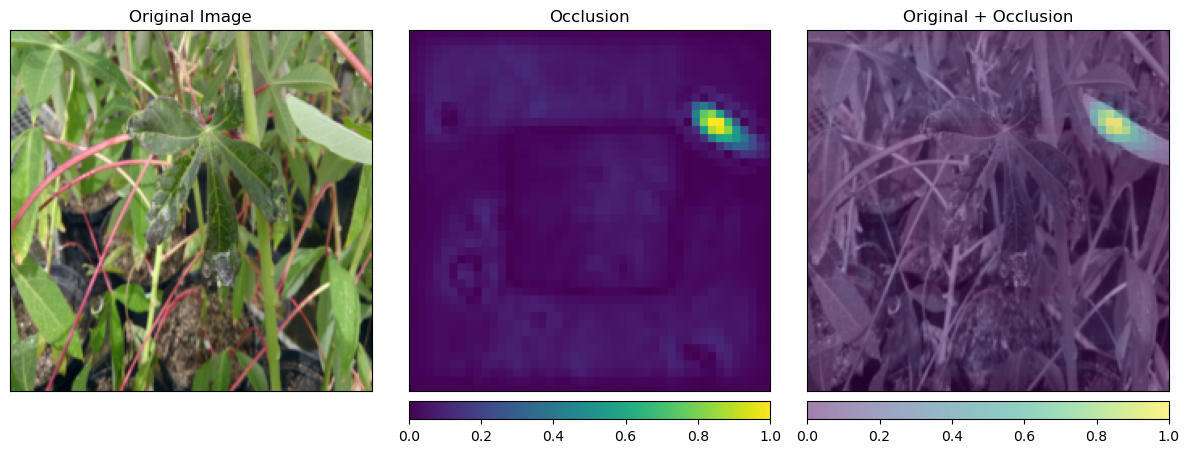

In [7]:
idx = 2

original_im = deprocess_image(x_test[idx])

_ = viz.visualize_image_attr_multiple(
    np.transpose(out[idx].squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(original_im.squeeze(), (0, 1, 2)), 
    ["original_image", "heat_map", "blended_heat_map"],
    ["all", "absolute_value", "absolute_value"],
    titles=['Original Image', 'Occlusion', 'Original + Occlusion'],
    cmap='viridis',
    show_colorbar=True,
    fig_size=(12, 10)
)

## PlantVillage-DA

In [8]:
occlusion = captum.attr.Occlusion(model_plantvillage_da)
out = occlusion.attribute(
    x_test,
    target=y_test,
    strides=(3, 5, 5),
    sliding_window_shapes=(3, 10, 10)
)

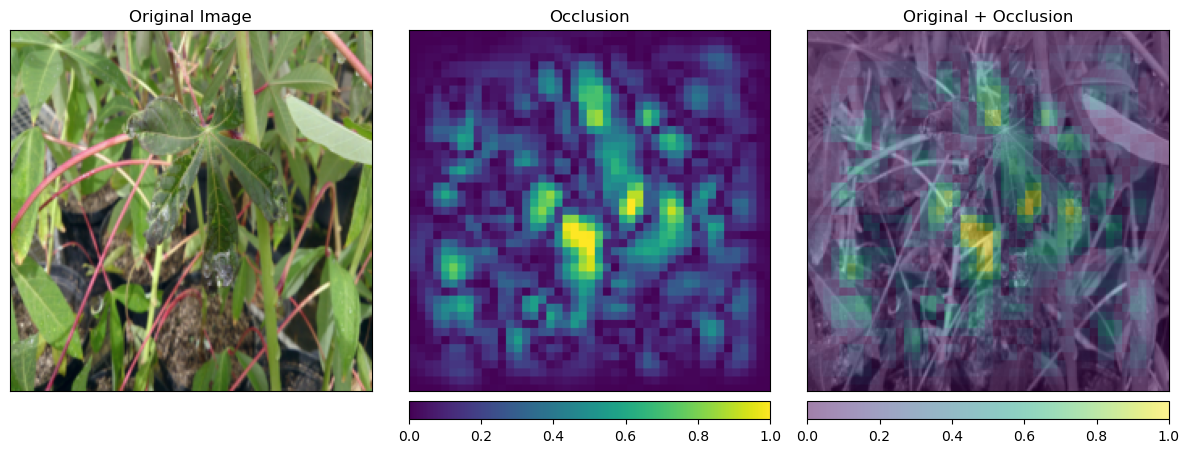

In [9]:
idx = 2

original_im = deprocess_image(x_test[idx])

_ = viz.visualize_image_attr_multiple(
    np.transpose(out[idx].squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(original_im.squeeze(), (0, 1, 2)), 
    ["original_image", "heat_map", "blended_heat_map"],
    ["all", "absolute_value", "absolute_value"],
    titles=['Original Image', 'Occlusion', 'Original + Occlusion'],
    cmap='viridis',
    show_colorbar=True,
    fig_size=(12, 10)
)

## PlantVillage-FT

In [10]:
occlusion = captum.attr.Occlusion(model_plantvillage_ft)
out = occlusion.attribute(
    x_test,
    target=y_test,
    strides=(3, 5, 5),
    sliding_window_shapes=(3, 10, 10)
)

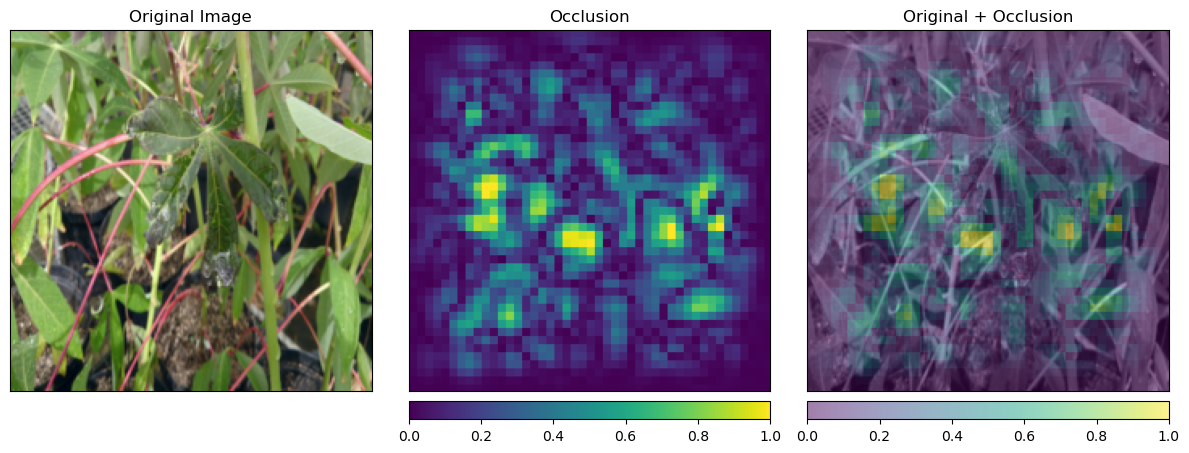

In [11]:
idx = 2

original_im = deprocess_image(x_test[idx])

_ = viz.visualize_image_attr_multiple(
    np.transpose(out[idx].squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(original_im.squeeze(), (0, 1, 2)), 
    ["original_image", "heat_map", "blended_heat_map"],
    ["all", "absolute_value", "absolute_value"],
    titles=['Original Image', 'Occlusion', 'Original + Occlusion'],
    cmap='viridis',
    show_colorbar=True,
    fig_size=(12, 10)
)

## ResNet50-DA

In [12]:
occlusion = captum.attr.Occlusion(model_resnet_da)
out = occlusion.attribute(
    x_test,
    target=y_test,
    strides=(3, 5, 5),
    sliding_window_shapes=(3, 10, 10)
)

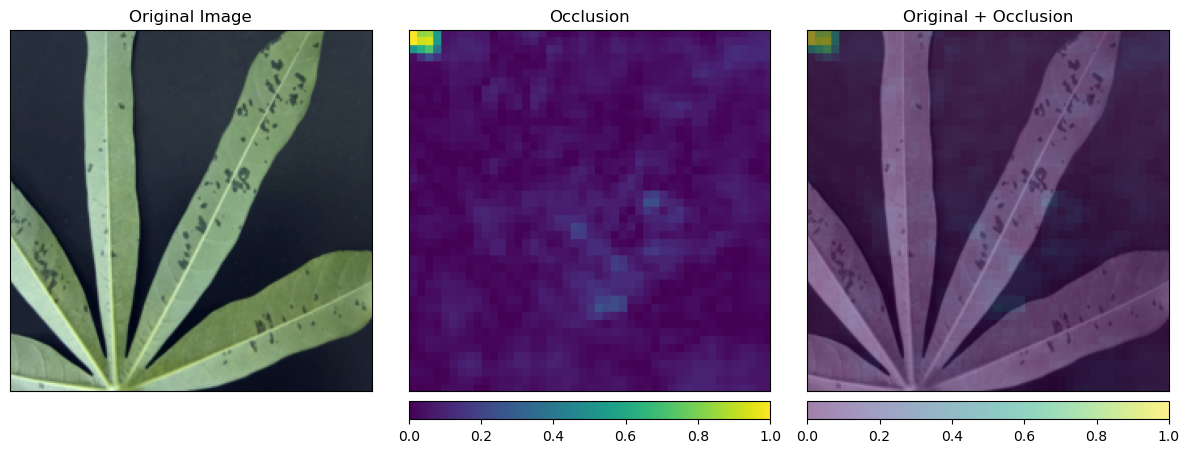

In [13]:
idx = 4

original_im = deprocess_image(x_test[idx])

_ = viz.visualize_image_attr_multiple(
    np.transpose(out[idx].squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(original_im.squeeze(), (0, 1, 2)), 
    ["original_image", "heat_map", "blended_heat_map"],
    ["all", "absolute_value", "absolute_value"],
    titles=['Original Image', 'Occlusion', 'Original + Occlusion'],
    cmap='viridis',
    show_colorbar=True,
    fig_size=(12, 10)
)

## ResNet50-FT

In [14]:
occlusion = captum.attr.Occlusion(model_resnet_ft)
out = occlusion.attribute(
    x_test,
    target=y_test,
    strides=(3, 5, 5),
    sliding_window_shapes=(3, 10, 10)
)

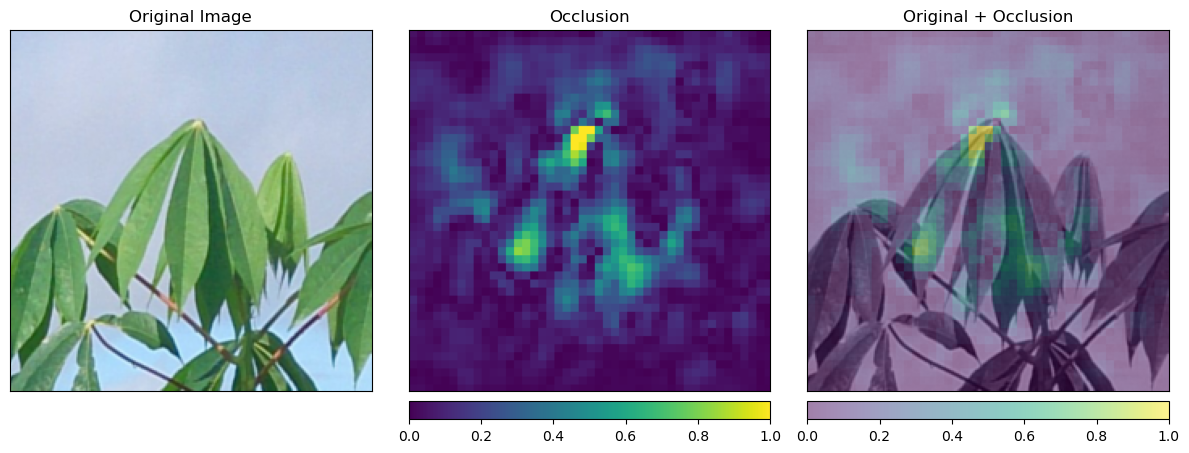

In [15]:
idx = 3

original_im = deprocess_image(x_test[idx])

_ = viz.visualize_image_attr_multiple(
    np.transpose(out[idx].squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(original_im.squeeze(), (0, 1, 2)), 
    ["original_image", "heat_map", "blended_heat_map"],
    ["all", "absolute_value", "absolute_value"],
    titles=['Original Image', 'Occlusion', 'Original + Occlusion'],
    cmap='viridis',
    show_colorbar=True,
    fig_size=(12, 10)
)